# Problem Set 9, Part Two: Due Tuesday, April 15 by 8am Eastern Daylight Time

## Name: David Millard

**Show your work on all problems!** Be sure to give credit to any
collaborators, or outside sources used in solving the problems. Note
that if using an outside source to do a calculation, you should use it
as a reference for the method, and actually carry out the calculation
yourself; it’s not sufficient to quote the results of a calculation
contained in an outside source.

Fill in your solutions in the notebook below, inserting markdown and/or code cells as needed.  Try to do reasonably well with the typesetting, but don't feel compelled to replicate my formatting exactly.  **You do NOT need to make random variables blue!**

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0,5.0)
plt.rcParams['font.size'] = 14

## 1. Project Proposals

Submit a proposal for a computational project, including a title and a
paragraph explaining the proposed project. The project should consist of
either investigation and presentation of a nonparametric statistical
method not covered this semester, or an in-depth numerical evaluation of
an analysis or comparison of analyses which we *have* covered. Describe
how you’d simulate or acquire the data, what analysis you’d perform, and
what properties you’d test.

**Done.**

## 2. Checking the Chi-Squared Approximation

### 2.1 Categorical Data with Hypothesized Probabilities

Consider a categorical data set with $N$ total observations and $c$ categories, where the number of observations in category $i$ is $O_i$.  The null hypothesis provides probabilities $\{p^{*}_{i}\}$ for the categories, with $\sum_{i=1}^c p^{*}_{i}=1$, and thus expected number counts $E_i=Np^{*}_i$. 
We wish to check the approximation that the chi-squared statistic
$$
\sum_{i=1}^c \frac{(O_i-E_i)^2}{E_i} = \sum_{i=1}^c \frac{O_i^2}{E_i} - N
$$
is approximately $\chi^2(c-1)$ distributed.

We make some choices for the parameters, including $N=100$ and $c=6$ and some arbitrarily chosen parameters, and define the expectations of the null hypothesis:

In [3]:
pstar_i = np.array([1,2,3,4,5,6])
pstar_i = pstar_i / np.sum(pstar_i)
c = len(pstar_i)
N = 100
E_i = N*pstar_i
print("E_i=",E_i)

E_i= [ 4.76190476  9.52380952 14.28571429 19.04761905 23.80952381 28.57142857]


Now we perform a Monte Carlo simulation by drawing a sample of size $N_{\rm monte}$ from a multinomial distribution with probabilities $\{p^*_i|i=1,\ldots,c\}$, obtaining $\{O^{(I)}_i|i=1,\ldots,c;I=1,\ldots,N_{\rm monte}\}$.  We use this to construct a null sample of $\chi^2$ statistics:
$$
W^{(I)} = \sum_{i=1}^c \frac{(O^{(I)}_i)^2}{E_i} - N
$$

In [4]:
Nmonte = 10**4
np.random.seed(20250403)
O_Ii = stats.multinomial(N,pstar_i).rvs(size=Nmonte)
O_Ii

array([[11, 11, 13, 18, 26, 21],
       [ 5, 13, 17, 19, 12, 34],
       [ 5,  4, 17, 20, 22, 32],
       ...,
       [ 6,  6, 17, 16, 30, 25],
       [12, 10, 16, 15, 25, 22],
       [ 2, 14, 18, 16, 21, 29]])

In [5]:
chi2_I = np.sum((O_Ii)**2/E_i[None,:],axis=-1) - N; chi2_I = np.round(chi2_I+1e-10,8)

We use this sample to evaluate empirical $p$-values at various statistic levels $w^*$,
$$
P(W\ge w^*)\approx \frac{1}{N_{\rm monte}}\sum_{I=1}^{N_{\rm monte}} I[W^{(I)}\ge w^*]
$$
We choose our $w^*$ levels to be all of the unique values present in the Monte Carlo sample (rounding off to 8 decimal places to avoid floating point ambiguities).  Note that this should be used with some caution, since a large simulation could produce a very big array in this way.  We also estimate $P(W\ge w^*)$ using the approximation that $W$ is $\chi^2(c-1)$ distributed.

In [6]:
chi2_c = np.unique(chi2_I)
print('%d unique $\chi^2$ values' % len(chi2_c))
nu = c-1
pexact_c = np.mean(chi2_I[None,:]>=chi2_c[:,None],axis=-1)
pchi2_c = stats.chi2(df=nu).sf(chi2_c)

1861 unique $\chi^2$ values


Now we plot the approximate $p$ value versus the exact one.

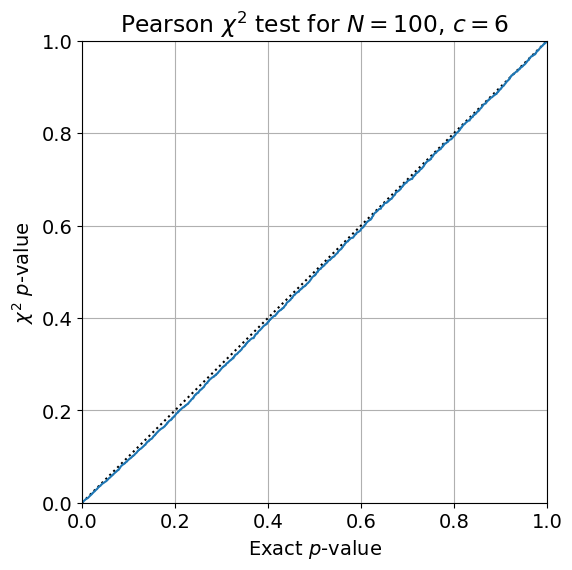

In [7]:
plt.figure(figsize=(6,6));
plt.plot([0,1],[0,1],'k:');
plt.plot(pexact_c,pchi2_c);
plt.title('Pearson $\chi^2$ test for $N=%d$, $c=%d$' % (N,c))
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.xlim(0,1);
plt.ylim(0,1);
plt.grid();

You can see, the agreement looks very good, but we can also zoom in on low $p$-values by plotting on a log scale

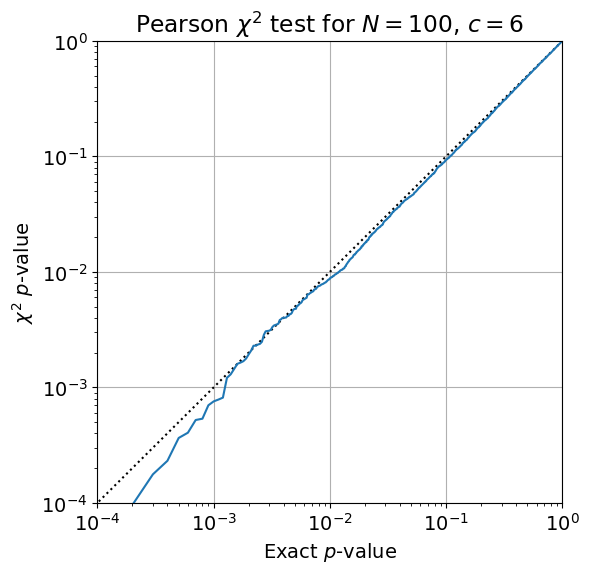

In [8]:
plt.figure(figsize=(6,6));
plt.loglog(pchi2_c,pchi2_c,'k:')
plt.loglog(pexact_c,pchi2_c)
plt.title('Pearson $\chi^2$ test for $N=%d$, $c=%d$' % (N,c))
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.xlim(1e-4,1);
plt.ylim(1e-4,1);
plt.grid();

There is some deviation at low false alarm rate, but that's likely Monte Carlo error.  To estimate the impact of Monte Carlo error, we could note that the one-sigma uncertainty on the number of Monte Carlo samples more extreme than a given $p$, $N_{\rm monte}p \pm \sqrt{N_{\rm monte}p(1-p)}$, which means the one sigma uncertainty on $p$ is $\sqrt{\frac{p(1-p)}{N_{\rm monte}}}$.  However, it turns out that, at very low probabilities, **that** normal approximation becomes inaccurate, and we need to use the actual binomial percentiles.  We can plot the 95\% band(s) for the "exact" $p$-value and check that the deviations between the empirical and approximate $p$-values are consistent with that band.  (Note that the bands are horizontal, since we're estimating the range of expected Monte Carlo estimates of the exact $p$-value which we would get if the chi-squared $p$-value were correct.)

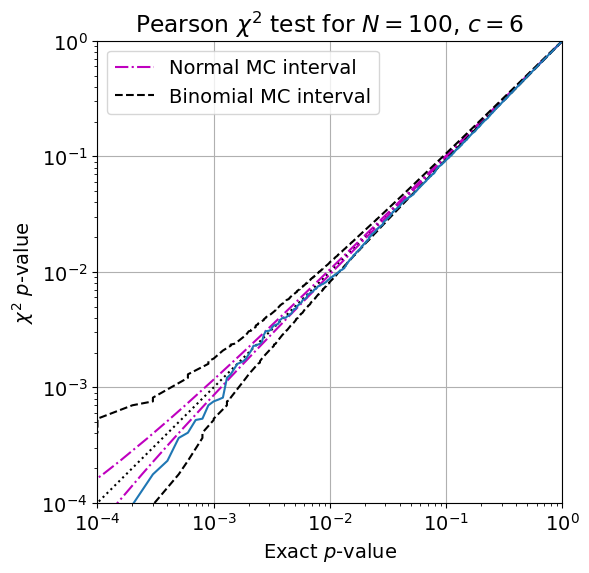

In [9]:
z975 = stats.norm.sf(0.025)
plt.figure(figsize=(6,6));
plt.loglog(pchi2_c,pchi2_c,'k:')
plt.loglog(pchi2_c-z975*np.sqrt(pchi2_c*(1-pchi2_c)/Nmonte),pchi2_c,'m-.',label='Normal MC interval')
plt.loglog(pchi2_c+z975*np.sqrt(pchi2_c*(1-pchi2_c)/Nmonte),pchi2_c,'m-.')
plt.loglog(stats.binom(Nmonte,pchi2_c).ppf(0.025)/Nmonte,pchi2_c,'k--',label='Binomial MC interval')
plt.loglog(stats.binom(Nmonte,pchi2_c).isf(0.025)/Nmonte,pchi2_c,'k--')
plt.loglog(pexact_c,pchi2_c)
plt.title('Pearson $\chi^2$ test for $N=%d$, $c=%d$' % (N,c))
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.xlim(1e-4,1);
plt.ylim(1e-4,1);
plt.legend();
plt.grid();

Note that if we had used `Nmonte=10**5` there would have been a detectable difference between the exact and approximate curves.

Alternatively, we can check this empirically by dividing the $N_{\rm monte}$ Monte Carlo samples into two groups and checking that the "exact" $p$-values estimated from the two halves differ from each other about as much as from the exact=approximate diagonal.

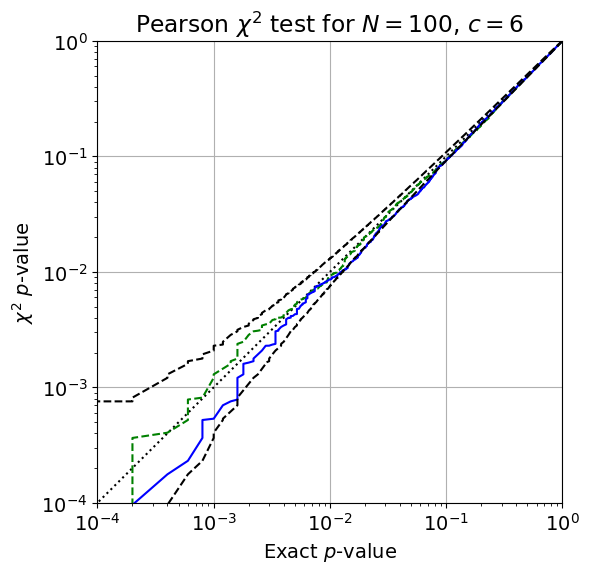

In [10]:
pexacthalf1_c = np.mean(chi2_I[None,::2]>=chi2_c[:,None],axis=-1)
pexacthalf2_c = np.mean(chi2_I[None,1::2]>=chi2_c[:,None],axis=-1)
plt.figure(figsize=(6,6));
plt.loglog(pchi2_c,pchi2_c,'k:');
plt.loglog(pexacthalf1_c,pchi2_c,'g--');
plt.loglog(pexacthalf2_c,pchi2_c,'b-');
plt.loglog(stats.binom(Nmonte/2,pchi2_c).ppf(0.025)/(Nmonte/2),pchi2_c,'k--')
plt.loglog(stats.binom(Nmonte/2,pchi2_c).isf(0.025)/(Nmonte/2),pchi2_c,'k--')
plt.title('Pearson $\chi^2$ test for $N=%d$, $c=%d$' % (N,c));
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.xlim(1e-4,1);
plt.ylim(1e-4,1);
plt.grid();

**(a)** Repeat the check for $N=10$, with the same $p^{*}_i$ values.  Where do you see discrepancies between the $p$-value calculated with the $\chi^2$ approximation and the estimated "exact $p$-value" from the Monte Carlo?  Check (using one or both of the demonstrated methods) whether they represent Monte Carlo uncertainties or an actual discrepancy.  (It may be appropriate to make this check on either the linear plot or the log plot, or both.)

In [20]:
N = 10
E_i = N*pstar_i
print("E_i=",E_i)

E_i= [4. 6.]


In [21]:
Nmonte = 10**4
np.random.seed(20250403)
O_Ii = stats.multinomial(N,pstar_i).rvs(size=Nmonte)
O_Ii

array([[8, 2],
       [5, 5],
       [4, 6],
       ...,
       [5, 5],
       [3, 7],
       [4, 6]])

In [22]:
chi2_I = np.sum((O_Ii)**2/E_i[None,:],axis=-1) - N; chi2_I = np.round(chi2_I+1e-10,8)

In [23]:
chi2_c = np.unique(chi2_I)
print('%d unique $\chi^2$ values' % len(chi2_c))
nu = c-1
pexact_c = np.mean(chi2_I[None,:]>=chi2_c[:,None],axis=-1)
pchi2_c = stats.chi2(df=nu).sf(chi2_c)

7 unique $\chi^2$ values


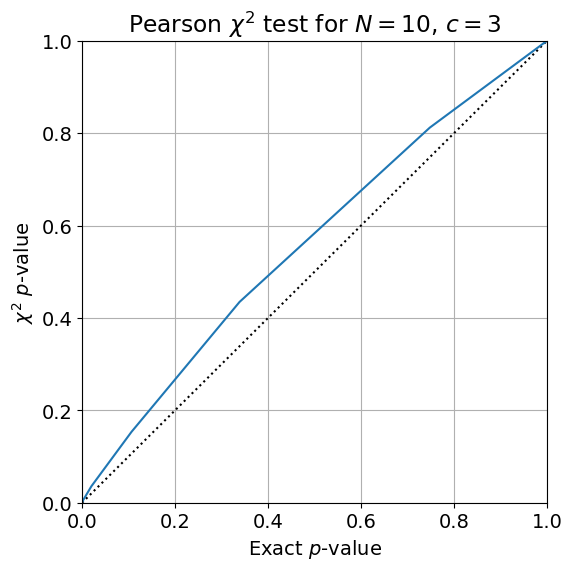

In [24]:
plt.figure(figsize=(6,6));
plt.plot([0,1],[0,1],'k:');
plt.plot(pexact_c,pchi2_c);
plt.title('Pearson $\chi^2$ test for $N=%d$, $c=%d$' % (N,c))
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.xlim(0,1);
plt.ylim(0,1);
plt.grid();

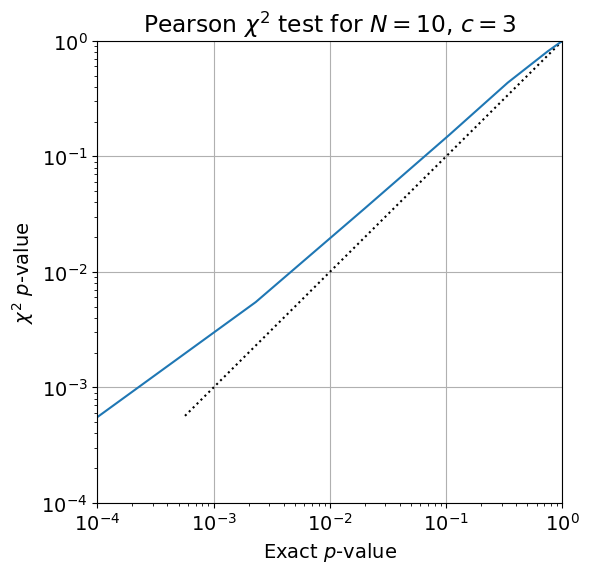

In [25]:
plt.figure(figsize=(6,6));
plt.loglog(pchi2_c,pchi2_c,'k:')
plt.loglog(pexact_c,pchi2_c)
plt.title('Pearson $\chi^2$ test for $N=%d$, $c=%d$' % (N,c))
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.xlim(1e-4,1);
plt.ylim(1e-4,1);
plt.grid();

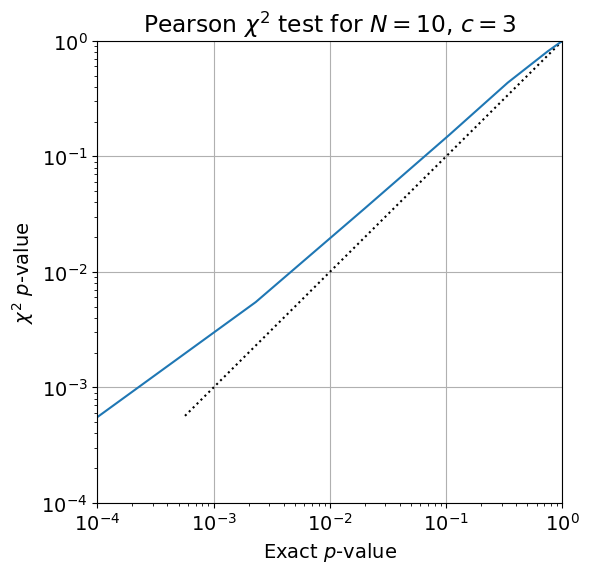

In [26]:
plt.figure(figsize=(6,6));
plt.loglog(pchi2_c,pchi2_c,'k:')
plt.loglog(pexact_c,pchi2_c)
plt.title('Pearson $\chi^2$ test for $N=%d$, $c=%d$' % (N,c))
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.xlim(1e-4,1);
plt.ylim(1e-4,1);
plt.grid();

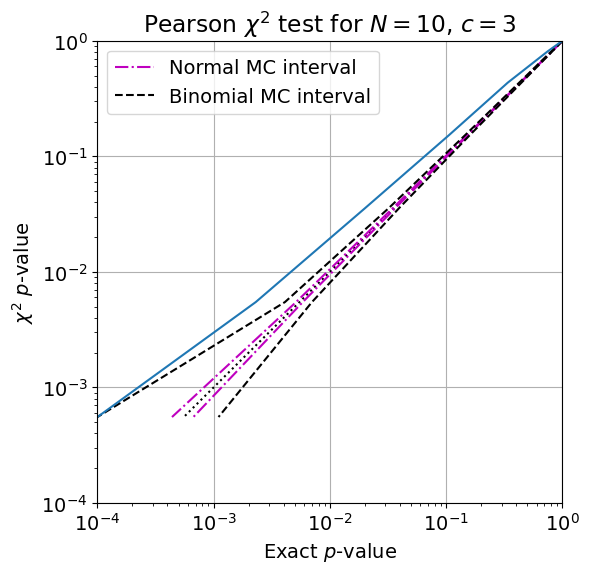

In [27]:
z975 = stats.norm.sf(0.025)
plt.figure(figsize=(6,6));
plt.loglog(pchi2_c,pchi2_c,'k:')
plt.loglog(pchi2_c-z975*np.sqrt(pchi2_c*(1-pchi2_c)/Nmonte),pchi2_c,'m-.',label='Normal MC interval')
plt.loglog(pchi2_c+z975*np.sqrt(pchi2_c*(1-pchi2_c)/Nmonte),pchi2_c,'m-.')
plt.loglog(stats.binom(Nmonte,pchi2_c).ppf(0.025)/Nmonte,pchi2_c,'k--',label='Binomial MC interval')
plt.loglog(stats.binom(Nmonte,pchi2_c).isf(0.025)/Nmonte,pchi2_c,'k--')
plt.loglog(pexact_c,pchi2_c)
plt.title('Pearson $\chi^2$ test for $N=%d$, $c=%d$' % (N,c))
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.xlim(1e-4,1);
plt.ylim(1e-4,1);
plt.legend();
plt.grid();

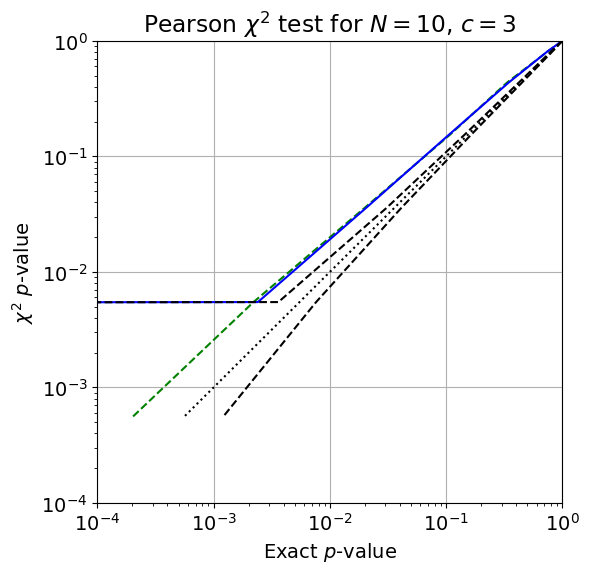

In [28]:
pexacthalf1_c = np.mean(chi2_I[None,::2]>=chi2_c[:,None],axis=-1)
pexacthalf2_c = np.mean(chi2_I[None,1::2]>=chi2_c[:,None],axis=-1)
plt.figure(figsize=(6,6));
plt.loglog(pchi2_c,pchi2_c,'k:');
plt.loglog(pexacthalf1_c,pchi2_c,'g--');
plt.loglog(pexacthalf2_c,pchi2_c,'b-');
plt.loglog(stats.binom(Nmonte/2,pchi2_c).ppf(0.025)/(Nmonte/2),pchi2_c,'k--')
plt.loglog(stats.binom(Nmonte/2,pchi2_c).isf(0.025)/(Nmonte/2),pchi2_c,'k--')
plt.title('Pearson $\chi^2$ test for $N=%d$, $c=%d$' % (N,c));
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.xlim(1e-4,1);
plt.ylim(1e-4,1);
plt.grid();

Discrepencies happen when the p-value is smaller.

### 2.2 Two-Way Contingency Tables

Next we consider a two-way $r\times c$ contingency table, with $\{O_{ij}|i=1,\ldots,r;j=1,\ldots,c\}$ representing the number of observations in row $i$ and columns $j$, where $r_i=\sum_{j=1}^c O_{ij}$, $c_j=\sum_{i=1}^r O_{ij}$, and $\sum_{i=1}^r r_i=\sum_{j=1}^c c_j=\sum_{i=1}^r\sum_{j=1}^c O_{ij}=N$.  The null hypothesis is now that the row and column placement of each observation is unrelated, which leads to an expected number count of $$E_{ij}=\frac{r_i c_j}{N}$$ and a statistic
$$
\sum_{i=1}^r\sum_{j=1}^c \frac{(O_{ij}-E_{ij})^2}{E_i} = \sum_{i=1}^r\sum_{j=1}^c \frac{O_{ij}^2}{E_{ij}} - N
$$
which is approximately $\chi^2([r-1][c-1])$ distributed.  We wish to check this by carrying out Monte Carlos under two different null hypotheses.
1. The total number of observations $N$ is fixed and the values $\{O_{ij}\}$ are a multinomial random vector for $N$ observations with probabilities $p^*_{ij}=p^*_{i\bullet} p^*_{\bullet j}$ for some arbitrarily chosen $\{p^*_{i\bullet}\}$ and $\{p^*_{\bullet j}\}$.
2. The number of observations $r_i$ in each row is fixed, and the $\{O_{ij}\}$ are a multinomial random vector for $r_i$ observations with probabilities $p^*_{\bullet j}$.

Note that in each case $E_{ij}$ is not determined by the probabilities $\{p^*_{i\bullet}\}$ and $\{p^*_{\bullet j}\}$ used for the Monte Carlo, but by the $r_i$ and $c_j$, which are determined from the observed data.

First we consider the case where only $N$ is fixed, and arbitrarily choose some probabilities for a $r=2$ by $c=6$ table with $N=100$ observations, and then generate $N_{\rm monte}$ random contingency tables with observation counts $\{O^{(I)}_{ij}\}$.

In [29]:
N = 100
pstar_i = np.array([.4,.6])
pstar_j = np.array([.2,.3,.5])
r = len(pstar_i)
c = len(pstar_j)
pstar_ij = pstar_i[:,None] * pstar_j[None,:]
Nmonte = 10**4
np.random.seed(202504031)
O_Iij = stats.multinomial(N,pstar_ij.flatten()).rvs(size=Nmonte).reshape((Nmonte,r,c))

We find the row and column totals $r^{(I)}_i=\sum_{j=1}^c O^{(I)}_{ij}$ and $c^{(I)}_j=\sum_{i=1}^r O^{(I)}_{ij}$ and the expected numbers $E^{(I)}_{ij}=r^{(I)}_i c^{(I)}_j/N$.  Note that in computing the $\chi^2$ statistic
$$
W^{(I)} = \sum_{i=1}^r \sum_{j=1}^c (O^{(I)}_{ij})^2/E^{(I)}_{ij} - N
$$
it may happen that, for a particular Monte Carlo iteration $I$, $r^{(I)}_i=0$ for some $i$ or $c^{(I)}_j=0$ for some $j$.  In this case $O^{(I)}_{ij}=E^{(I)}_{ij}=0$ for that $i$ or $j$.  Since we want the contribution to the sum to be zero in such cases, we add a small regularizing term of $10^{-12}$ in the denominator to avoid having the computer evaluate $0/0$ and get a `NaN`.

In [30]:
r_Ii = np.sum(O_Iij,axis=-1)
c_Ij = np.sum(O_Iij,axis=1)
E_Iij = r_Ii[:,:,None] * c_Ij[:,None,:] / N
chi2_I = np.sum(O_Iij**2/(E_Iij+1e-12),axis=(1,2)) - N; chi2_I = np.round(chi2_I+1e-10,8)

We evaluate the empirical "exact" $p$-value and the one from the $\chi^2$ approximation as before.

In [31]:
nu = (r-1)*(c-1)
chi2_c = np.unique(chi2_I)
pexact_c = np.mean(chi2_I[None,:]>=chi2_c[:,None],axis=-1)
pchi2_c = stats.chi2(df=nu).sf(chi2_c)

Now we wish to compute the exact $p$-values in the case where we fix the row totals $\{r_i\}$.  The indexing is a bit complicated if we write it out for general $r$, so let's take some shortcuts based on the fact that we chose $r=2$ above.  We'll keep the same $p_{\bullet j}$, and we'll set $r_1$ to be $Np^{*}_{1\bullet}$, rounded down, and $r_2$ to be $N-r_2$.

In [32]:
# Note: this assumes r=2
r1 = int(N*pstar_i[0])
r2 = N - r1
print(r1,r2)

40 60


Now we simulate $\{O^{(I)}_{1j}\}$ as a multinomial with $r_1$ observations and $\{O^{(I)}_{2j}\}$ as a multinomial with $r_2$ observations, using the probabilities $\{p_{\bullet j}\}$.  We can then calculate $c^{(I)}_j=\sum_{i=1}^2 O^{(I)}_{ij}$, and $E^{(I)}_{ij}=r_i c^{(I)}_j/N$, and the associated chi-squared.

In [33]:
Nmonte = 10**4
np.random.seed(202504032)
O1_Ij = stats.multinomial(r1,pstar_j).rvs(size=Nmonte)
O2_Ij = stats.multinomial(r2,pstar_j).rvs(size=Nmonte)
c_Ij = O1_Ij + O2_Ij
E1_Ij = r1 * c_Ij / N
E2_Ij = r2 * c_Ij / N
chi2row_I = np.sum(O1_Ij**2/(E1_Ij+1e-12),axis=-1) + np.sum(O2_Ij**2/(E2_Ij+1e-12),axis=-1) - N
chi2row_I = np.round(chi2row_I+1e-10,8)

Now we calculate the Monte Carlo probabilities as before:

In [34]:
nu = (r-1)*(c-1)
chi2row_c = np.unique(chi2row_I)
pexactrow_c = np.mean(chi2row_I[None,:]>=chi2row_c[:,None],axis=-1)
pchi2row_c = stats.chi2(df=nu).sf(chi2row_c)

We plot the two different "exact" $p$-values using the different assumptions:

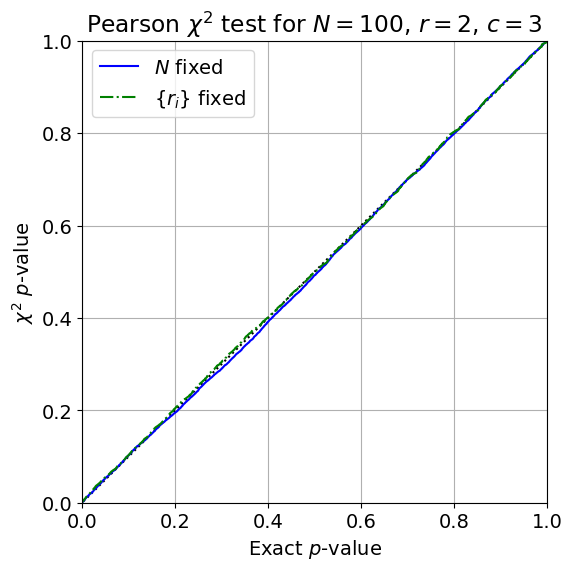

In [35]:
plt.figure(figsize=(6,6));
plt.plot(pchi2_c,pchi2_c,'k:');
plt.plot(pexact_c,pchi2_c,'b-',label=r'$N$ fixed');
plt.plot(pexactrow_c,pchi2row_c,'g-.',label=r'$\{r_i\}$ fixed');
plt.title('Pearson $\chi^2$ test for $N=%d$, $r=%d$, $c=%d$' % (N,r,c));
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.legend(loc='upper left');
plt.xlim(0,1);
plt.ylim(0,1);
plt.grid();

**(b)** Comment on the agreement between the $\chi^2$ approximation and the empirically estimated exact $p$-value in the two cases.

The $\chi^2$ approximation and the empirically estimated exact $p$-value agree more at the tails and less towards the median of the distribution.

**(c)** We can also examine the small $p$-value behavior on a log plot:

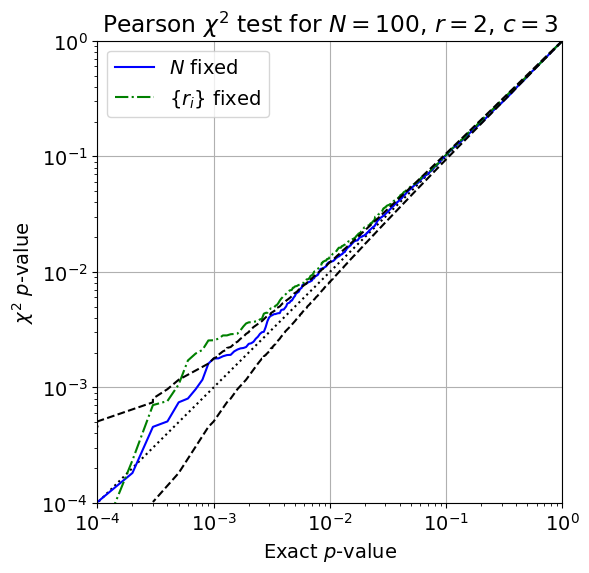

In [36]:
plt.figure(figsize=(6,6));
plt.loglog(pchi2_c,pchi2_c,'k:');
plt.loglog(pexact_c,pchi2_c,'b-',label=r'$N$ fixed');
plt.loglog(pexactrow_c,pchi2row_c,'g-.',label=r'$\{r_i\}$ fixed');
plt.loglog(stats.binom(Nmonte,pchi2_c).ppf(0.025)/Nmonte,pchi2_c,'k--')
plt.loglog(stats.binom(Nmonte,pchi2_c).isf(0.025)/Nmonte,pchi2_c,'k--')
plt.title('Pearson $\chi^2$ test for $N=%d$, $r=%d$, $c=%d$' % (N,r,c))
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.legend(loc='upper left');
plt.xlim(1e-4,1);
plt.ylim(1e-4,1);
plt.grid();

Is there a difference between the two empirical $p$-value curves and the $\chi^2$ approximation?  Can it be explained by Monte Carlo fluctuations?

Yes there is a difference. It cannot be fully explained by the MC fluctuation. Because values fall outside of the dotted bounds it's likely that the deviation is not just from randomness, but instead reflects inherent differences between the empirical null distribution and the $\chi^2$ approximation.

**(d)** Repeat the contingency table Monte Carlos with $N=10$ and the same proportions (so that $r_1=6$ and $r_2=4$).

In [38]:
N = 10
pstar_i = np.array([.4,.6])
pstar_j = np.array([.2,.3,.5])
r = len(pstar_i)
c = len(pstar_j)
pstar_ij = pstar_i[:,None] * pstar_j[None,:]
Nmonte = 10**4
np.random.seed(202504031)
O_Iij = stats.multinomial(N,pstar_ij.flatten()).rvs(size=Nmonte).reshape((Nmonte,r,c))

In [39]:
r_Ii = np.sum(O_Iij,axis=-1)
c_Ij = np.sum(O_Iij,axis=1)
E_Iij = r_Ii[:,:,None] * c_Ij[:,None,:] / N
chi2_I = np.sum(O_Iij**2/(E_Iij+1e-12),axis=(1,2)) - N; chi2_I = np.round(chi2_I+1e-10,8)

In [40]:
nu = (r-1)*(c-1)
chi2_c = np.unique(chi2_I)
pexact_c = np.mean(chi2_I[None,:]>=chi2_c[:,None],axis=-1)
pchi2_c = stats.chi2(df=nu).sf(chi2_c)

In [41]:
# Note: this assumes r=2
r1 = int(N*pstar_i[0])
r2 = N - r1
print(r1,r2)

4 6


In [42]:
Nmonte = 10**4
np.random.seed(202504032)
O1_Ij = stats.multinomial(r1,pstar_j).rvs(size=Nmonte)
O2_Ij = stats.multinomial(r2,pstar_j).rvs(size=Nmonte)
c_Ij = O1_Ij + O2_Ij
E1_Ij = r1 * c_Ij / N
E2_Ij = r2 * c_Ij / N
chi2row_I = np.sum(O1_Ij**2/(E1_Ij+1e-12),axis=-1) + np.sum(O2_Ij**2/(E2_Ij+1e-12),axis=-1) - N
chi2row_I = np.round(chi2row_I+1e-10,8)

In [43]:
nu = (r-1)*(c-1)
chi2row_c = np.unique(chi2row_I)
pexactrow_c = np.mean(chi2row_I[None,:]>=chi2row_c[:,None],axis=-1)
pchi2row_c = stats.chi2(df=nu).sf(chi2row_c)

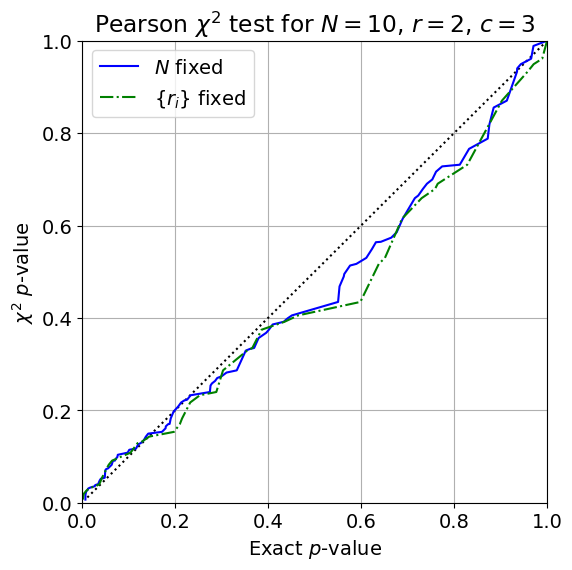

In [44]:
plt.figure(figsize=(6,6));
plt.plot(pchi2_c,pchi2_c,'k:');
plt.plot(pexact_c,pchi2_c,'b-',label=r'$N$ fixed');
plt.plot(pexactrow_c,pchi2row_c,'g-.',label=r'$\{r_i\}$ fixed');
plt.title('Pearson $\chi^2$ test for $N=%d$, $r=%d$, $c=%d$' % (N,r,c));
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.legend(loc='upper left');
plt.xlim(0,1);
plt.ylim(0,1);
plt.grid();

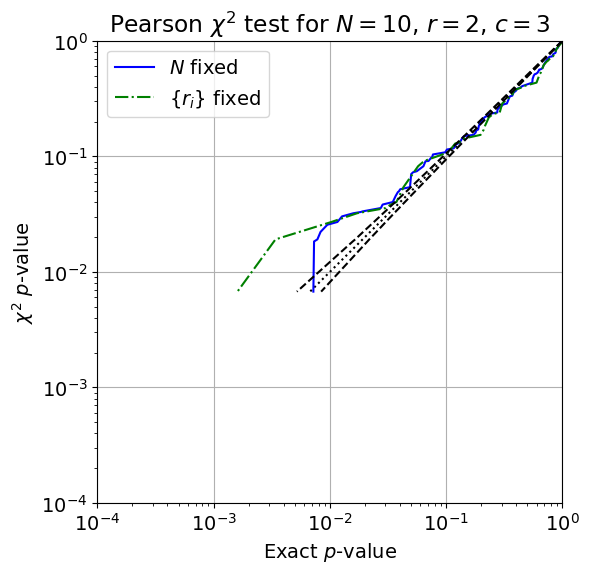

In [45]:
plt.figure(figsize=(6,6));
plt.loglog(pchi2_c,pchi2_c,'k:');
plt.loglog(pexact_c,pchi2_c,'b-',label=r'$N$ fixed');
plt.loglog(pexactrow_c,pchi2row_c,'g-.',label=r'$\{r_i\}$ fixed');
plt.loglog(stats.binom(Nmonte,pchi2_c).ppf(0.025)/Nmonte,pchi2_c,'k--')
plt.loglog(stats.binom(Nmonte,pchi2_c).isf(0.025)/Nmonte,pchi2_c,'k--')
plt.title('Pearson $\chi^2$ test for $N=%d$, $r=%d$, $c=%d$' % (N,r,c))
plt.xlabel('Exact $p$-value');
plt.ylabel('$\chi^2$ $p$-value');
plt.legend(loc='upper left');
plt.xlim(1e-4,1);
plt.ylim(1e-4,1);
plt.grid();

Is there a detectable (beyond Monte Carlo fluctuations) difference between the empirical $p$-values whether $N$ or $\{r_i\}$ is held constant, and between each of them and the $\chi^2$ approximation?

Yes there is a detectable difference between the empirical empirical $p$-value and the $\chi^2$ approximation. They fall outside of the dotted bounds.  